In [1]:
!pip install impedance
import importlib
import Manuel_echem_function
importlib.reload(Manuel_echem_function)
from Manuel_echem_function import *
import pandas as pd
import os, io
import requests
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
from nomad_api_calls import *

%matplotlib widget

import warnings
warnings.filterwarnings("ignore")

## Plotting preferences 

color_cm = ["#004f84ff", "#6cabe9ff", "#d15e57ff", "#ff7f2aff","#808080ff","#8787deff"]
# Expanded with 5 additional colors that harmonize with the original palette
color_cm = color_cm + ["#00a591ff", "#b2df8aff", "#f9c74fff", "#178eaeff", "#a70d88ff", "#373438ff",]


matplotlib.rc('font', size= 14) # controls default text sizes
matplotlib.rc('axes', titlesize=14) # fontsize of the axes title
matplotlib.rc('axes', labelsize=14) # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14) # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14) # fontsize of the tick labels
matplotlib.rc('legend', fontsize= 10) # legend fontsize
matplotlib.rc('figure', titlesize=14) # fontsize of the figure title



In [2]:
url = "https://nomad-hzb-se.de/nomad-oasis/api/v1"
token = os.environ['NOMAD_CLIENT_ACCESS_TOKEN'] 
if len(token) > 10:
    print("Token Recieved")

Token Recieved


# Step 1: Plot the data

0
1
2
3
4
5
6
7
8


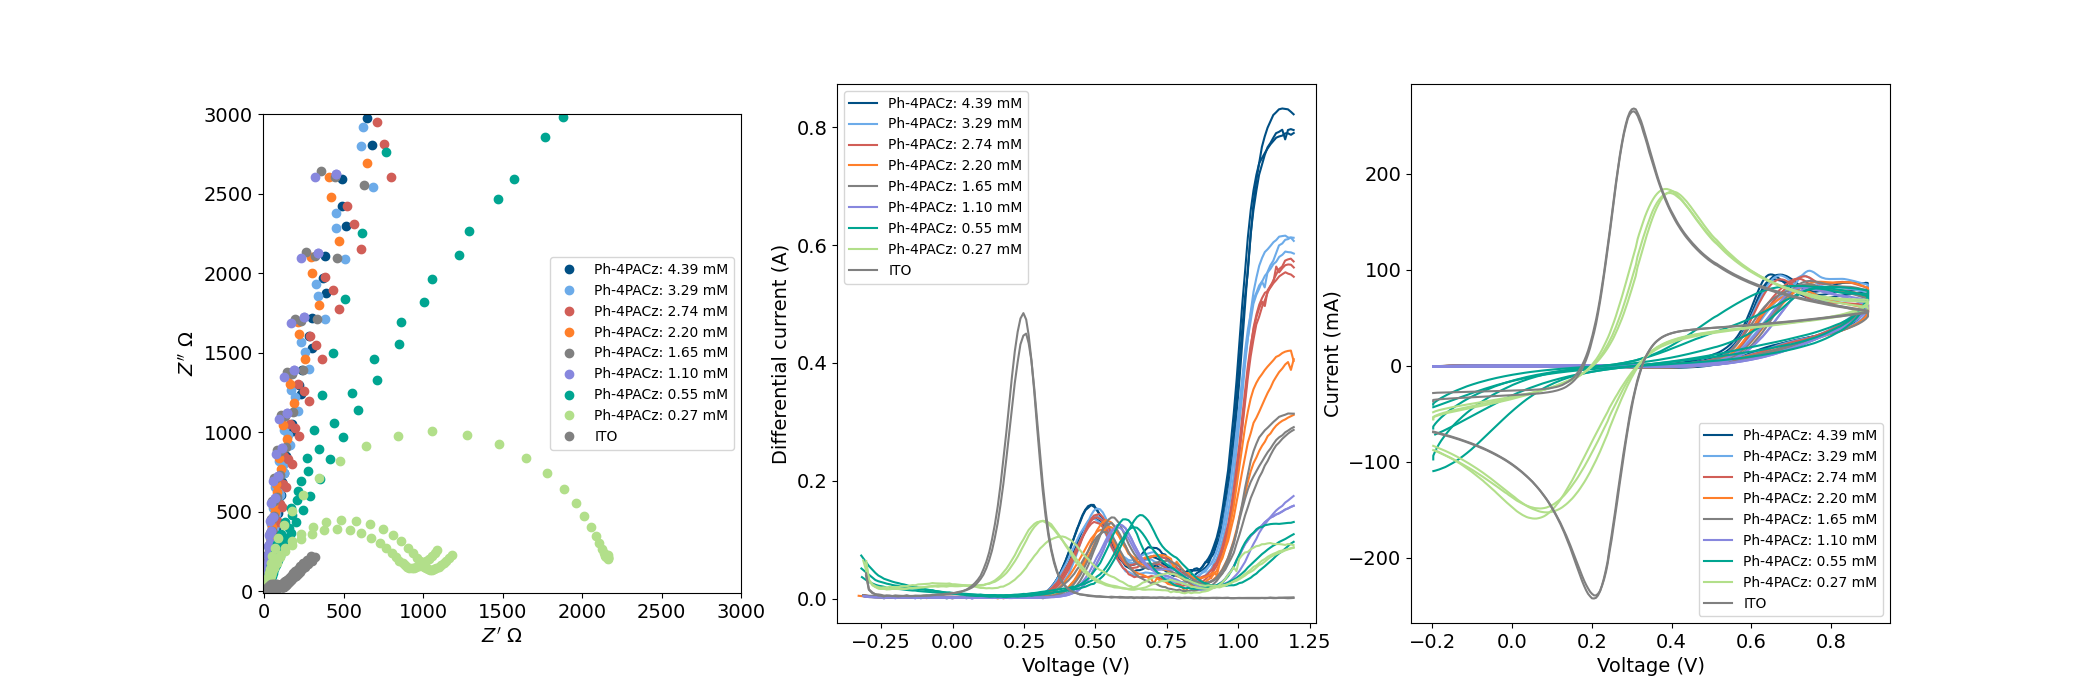

In [3]:
plt.close("all")
file_id=[["HZB_Echem_161_1_C-10","HZB_Echem_161_1_C-9","HZB_Echem_161_1_C-8"],
         ["HZB_Echem_161_2_C-7", "HZB_Echem_161_2_C-6","HZB_Echem_161_2_C-5"],
         ["HZB_Echem_161_3_C-4", "HZB_Echem_161_3_C-3","HZB_Echem_161_3_C-2"],
         ["HZB_Echem_161_4_C-1", "HZB_Echem_161_4_C-16", "HZB_Echem_161_4_C-30"],
         ["HZB_Echem_161_5_C-27", "HZB_Echem_161_5_C-28", "HZB_Echem_161_5_C-24"],
         ["HZB_Echem_161_6_C-13", "HZB_Echem_161_6_C-13", "HZB_Echem_161_6_C-12"],
         ["HZB_Echem_161_7_C-11", "HZB_Echem_161_7_C-24", "HZB_Echem_161_7_C-25"],
         ["HZB_Echem_161_8_C-26", "HZB_Echem_161_8_C-14", "HZB_Echem_161_8_C-19"],
         ["HZB_Echem_161_9_C-21",  "HZB_Echem_161_9_C-23"]]

fig,axis=plt.subplots(1,3,figsize=(7*3, 7) )

       
reference_values=[0.05,0.1,0.2,0.3,0.5]  # Set of scan speed
threshold=0.02
scan_speed=1       # From the reference_values
cycle_number=1


for jj,subbatch in enumerate(file_id):
    
    color=color_cm[jj]
    print(jj)
    for ii,file in enumerate(subbatch):

        if ii==0:            
            #Get Concentration and SAM information from NOMAD
            info = get_specific_data_of_sample(url, token, file, "HySprint_SpinCoating")
            
            if not info:
                label="ITO"
                color="grey"
            else:
                material=info[0]["layer"][0]['layer_material_name']
                concentration=info[0]["solution"][0]["solution_details"]["solute"][0]["concentration_mol"]
                label=f"{material}: {concentration*1e6:.2f} mM"

        else: 
            label=None
    
        ## EIS plot
        axs=axis[0]
        data = get_specific_data_of_sample(url, token, file, "HySprint_ElectrochemicalImpedanceSpectroscopy")
        axs.plot(data[0]["z_real"],data[0]["z_imaginary"],"o",color=color,label=label)
        
        axs.set_aspect('equal')
        axs.set_xlabel(r"$Z'$ $\Omega$")
        axs.set_ylabel(r"$Z''$ $\Omega$")
        axs.set_xlim([-10,3000])
        axs.set_ylim([-10,3000])   
        axs.legend()

        ## DPV plot
        axs=axis[1]
        data = get_specific_data_of_sample(url, token, file, "HySprint_DifferentialPulseVoltammetry")
        axs.plot(data[0]["voltage"],data[0]["current"],color=color,label=label)
        axs.set_xlabel(r"Voltage (V)")
        axs.set_ylabel(r"Differential current (A)")  
        axs.legend()

        ## CV plot
        axs=axis[2]
        data = get_specific_data_of_sample(url, token, file, "HySprint_CyclicVoltammetry")

        CV_df=CV_analysis_NOMAD(data[0]["cycles"][0]["time"],data[0]["cycles"][0]["voltage"],data[0]["cycles"][0]["current"],reference_values,threshold,plot_SS=False)
        
        df1 = CV_df[CV_df['Speed_bin'] == "0.05"]
        df1=assign_cycles_NOMAD(df1)
        df_cycle2 = df1[df1["Cycle"] == cycle_number]
        axs.plot(df_cycle2["voltage"], df_cycle2["current"]*1e3,color=color, label=label)
        axs.set_xlabel(r"Voltage (V)")
        axs.set_ylabel(r"Current (mA)")  
        axs.legend()

plt.show()


# Deeper analysis - EIS

In [1]:
plt.close("all")
file_id=[["HZB_Echem_161_1_C-10","HZB_Echem_161_1_C-9","HZB_Echem_161_1_C-8"],
         ["HZB_Echem_161_2_C-7", "HZB_Echem_161_2_C-6","HZB_Echem_161_2_C-5"],
         ["HZB_Echem_161_3_C-4", "HZB_Echem_161_3_C-3","HZB_Echem_161_3_C-2"],
         ["HZB_Echem_161_4_C-1", "HZB_Echem_161_4_C-16", "HZB_Echem_161_4_C-30"],
         ["HZB_Echem_161_5_C-27", "HZB_Echem_161_5_C-28", "HZB_Echem_161_5_C-24"],
         ["HZB_Echem_161_6_C-13", "HZB_Echem_161_6_C-13", "HZB_Echem_161_6_C-12"],
         ["HZB_Echem_161_7_C-11", "HZB_Echem_161_7_C-24", "HZB_Echem_161_7_C-25"],
         ["HZB_Echem_161_8_C-26", "HZB_Echem_161_8_C-14", "HZB_Echem_161_8_C-19"],
         ["HZB_Echem_161_9_C-21",  "HZB_Echem_161_9_C-23"]]

fig,axis=plt.subplots(1,3,figsize=(7*3, 7) )

       
reference_values=[0.05,0.1,0.2,0.3,0.5]  # Set of scan speed
threshold=0.02
scan_speed=1       # From the reference_values
cycle_number=1

Rct_experiment=[]
label_experiment=[]
for jj,subbatch in enumerate(file_id):
    
    color=color_cm[jj]
    print(jj)
    Rct=[]
    for ii,file in enumerate(subbatch):

        if ii==0:            
            #Get Concentration and SAM information from NOMAD
            A=get_sample_description(url, token, [file])
            label=A[file]
            label_experiment.append(label)

        else: 
            label=None

        data = get_specific_data_of_sample(url, token, file, "HySprint_ElectrochemicalImpedanceSpectroscopy")        
        dataEIS=data

        # Convert everything to NumPy arrays
        freq = np.array(data[0]["frequency"], dtype=float)
        Zr   = np.array(dataEIS[0]["z_real"], dtype=float)
        Zi   = -np.array(dataEIS[0]["z_imaginary"], dtype=float)
        Z = Zr + 1j * Zi

        # EIS fit
            
        if np.max(Zr)<3000:

            # Create mask for frequencies lower than 10^5 Hz
            mask = (freq < 2e5) & (freq > 1e-2)   # or: mask = freq < 10**5
            frequencies, Z = preprocessing.ignoreBelowX(freq[mask],Z[mask])
        
            circuitA = 'R0-p(R2-W1,CPE1)'
            initial_guess = [None, 8, 500, 1e-5,0.5]
            constants={"R0":16.5}
            Z_fit,circuit=impedance_fit2(frequencies,Z,circuitA,initial_guess,constants)
            Rct.append(circuit.parameters_[0])
            
        else:
            
            # Create mask for frequencies lower than 10^5 Hz
            mask = (freq < 2e5) & (freq > 0.5e1)   # or: mask = freq < 10**5
            frequencies, Z = preprocessing.ignoreBelowX(freq[mask],Z[mask])
            
            circuitA = 'p(R1,CPE1,R3)-p(R5,CPE2)-R4'
            initial_guess = [1e6, 4.13e-06, 0.87,1e6,1e-6,0.9,1e8,None]
            constants={"R4":16.2}
            
            Z_fit,circuit=impedance_fit2(frequencies,Z,circuitA,initial_guess,constants)
            Rct.append(circuit.parameters_[0])

       #else:
       #     circuitA='R0-p(R1,CPE1)-p(R2,CPE2)-p(R2,CPE2)'
       #     initial_guess=[None, 1e4, 1e-6,0.9,1e7,1e-6,0.9,1e8,1e-6,0.9]  # R0, R1, C1
       #     constants={"R0":16.5}
       #     Z_fit,circuit=impedance_fit2(frequencies,Z,circuitA,initial_guess,constants)

        
         ## EIS plot
        axs=axis[0]
        axs.plot(data[0]["z_real"],data[0]["z_imaginary"],"o",color=color,label=label)

        axs.plot(np.real(Z_fit),-np.imag(Z_fit), "-",color=color)

        
        axs.set_aspect('equal')
        axs.set_xlabel(r"$Z'$ $\Omega$")
        axs.set_ylabel(r"$Z''$ $\Omega$")
        axs.set_xlim([-10,10000])
        axs.set_ylim([-10,10000])   
        axs.legend()
        
        axs=axis[1]
        axs.loglog(data[0]["frequency"],data[0]["z_modulus"],".",color=color,label=label)
        axs.loglog(frequencies,np.abs(Z_fit),"-",color=color)

        axs.set_ylabel("|Z| (Ohm)")
        axs.set_xlabel(r"Frequency (Hz)")

        axs=axis[2]
        axs.semilogx(data[0]["frequency"],data[0]["z_angle"], ".", color=color)
        axs.semilogx(frequencies,np.angle(Z_fit, deg=True), "-", color=color)

        axs.set_ylabel(r"Phase (Degree)", color=color)
        axs.set_xlabel(r"Frequency (Hz)")

    Rct_experiment.append(Rct)
plt.tight_layout()


NameError: name 'plt' is not defined

In [59]:
Rct_ITO=Rct_experiment[-1]
meanITO=np.mean(Rct_experiment[-1])
for ii,Rct_val in enumerate(Rct_experiment):
    mean=np.mean(Rct_val)
    std=np.std(Rct_val)
    theta=1-meanITO/mean
    print(f"{label_experiment[ii]} Coverage:{theta} with ")

SAM: 2.0mg/mL Coverage:0.9986982496459084 with 
SAM: 1.5mg/mL Coverage:0.9981502832850833 with 
SAM: 1.25mg/mL Coverage:0.9980237842455579 with 
SAM: 1.00mg/mL Coverage:0.9982920803109958 with 
SAM: 0.75mg/mL Coverage:0.9984074056402665 with 
SAM: 0.50mg/mL Coverage:0.9988670794335867 with 
SAM: 0.25mg/mL Coverage:0.9995477402088605 with 
SAM: 0.125mg/mL Coverage:0.9445286721970846 with 
ITO Coverage:0.0 with 


In [52]:
Rct_ITO = Rct_experiment[-1]
meanITO = np.mean(Rct_ITO)

theta_vals = []

for Rct_val in Rct_experiment:
    mean = np.mean(Rct_val)
    theta = 1 - meanITO / mean
    theta_vals.append(theta)

theta_vals = np.array(theta_vals)
theta_std = np.std(theta_vals)
theta_std

np.float64(0.3121526142785677)

In [29]:
circuit = 'R0-p(R2-W1,CPE1)'
initial_guess = [16.5, 8, 500, 1e-5,0.5]


# Convert everything to NumPy arrays
freq = np.array(data[0]["frequency"], dtype=float)
Zr   = np.array(dataEIS[0]["z_real"], dtype=float)
Zi   = -np.array(dataEIS[0]["z_imaginary"], dtype=float)

Z = Zr + 1j * Zi
# Create mask for frequencies lower than 10^5 Hz
mask = freq < 1e5     # or mask = freq < 10**5
frequencies, Z = preprocessing.ignoreBelowX(freq[mask],Z[mask])
circuit = CustomCircuit(circuit, initial_guess=initial_guess)
        
circuit.fit(frequencies, Z)
Z_fit = circuit.predict(frequencies)



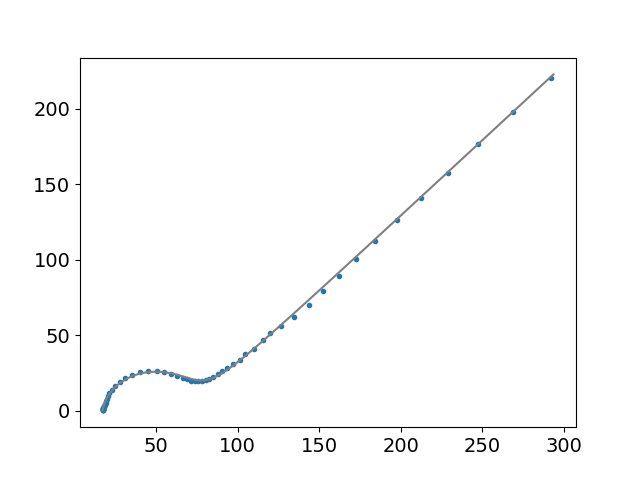

In [32]:
plt.figure()
plt.plot(Zr[mask],-Zi[mask],".")
plt.plot(np.real(Z_fit),-np.imag(Z_fit), "-",color=color)

plt.show()

 Check this article: https://doi.org/10.1016/j.electacta.2025.146231

0
[]
[]
[]
1
[]
[]
[]
2
[]
[]
[]
3
[]
[]
[]
4
[]
[]
[]
5
[]
[]
[]
6
[]
[]
[]
7
[]
[]
[]
8
[]
[]


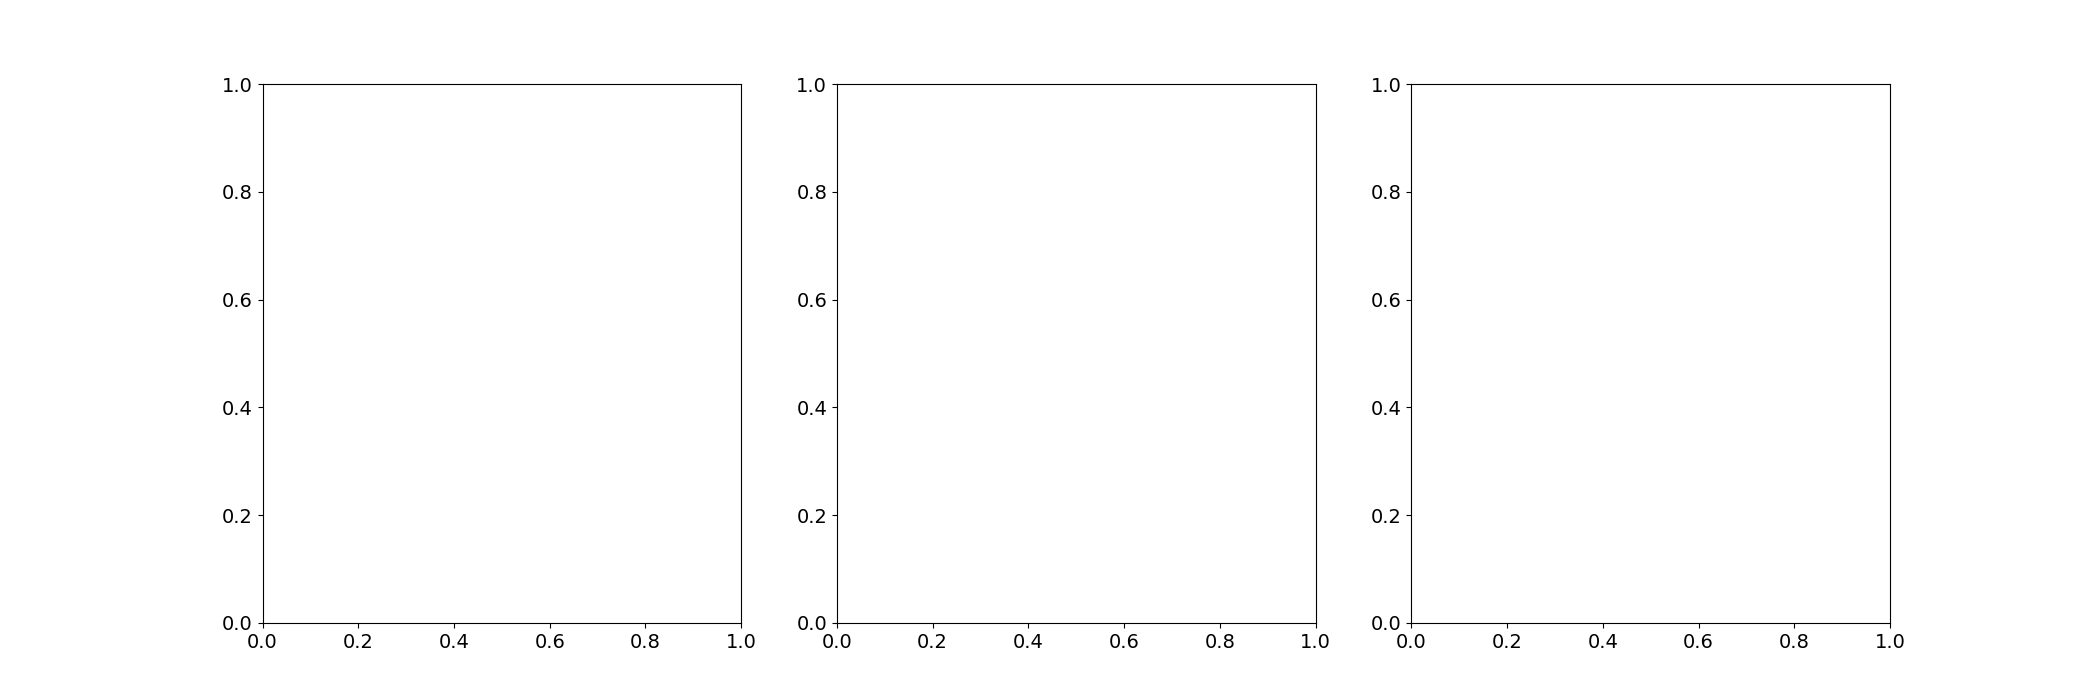

In [71]:
plt.close("all")
file_id=[["HZB_Echem_161_1_C-10","HZB_Echem_161_1_C-9","HZB_Echem_161_1_C-8"],
         ["HZB_Echem_161_2_C-7", "HZB_Echem_161_2_C-6","HZB_Echem_161_2_C-5"],
         ["HZB_Echem_161_3_C-4", "HZB_Echem_161_3_C-3","HZB_Echem_161_3_C-2"],
         ["HZB_Echem_161_4_C-1", "HZB_Echem_161_4_C-16", "HZB_Echem_161_4_C-30"],
         ["HZB_Echem_161_5_C-27", "HZB_Echem_161_5_C-28", "HZB_Echem_161_5_C-24"],
         ["HZB_Echem_161_6_C-13", "HZB_Echem_161_6_C-13", "HZB_Echem_161_6_C-12"],
         ["HZB_Echem_161_7_C-11", "HZB_Echem_161_7_C-24", "HZB_Echem_161_7_C-25"],
         ["HZB_Echem_161_8_C-26", "HZB_Echem_161_8_C-14", "HZB_Echem_161_8_C-19"],
         ["HZB_Echem_161_9_C-21",  "HZB_Echem_161_9_C-23"]]

fig,axis=plt.subplots(1,3,figsize=(7*3, 7) )

       
reference_values=[0.05,0.1,0.2,0.3,0.5]  # Set of scan speed
threshold=0.02
scan_speed=1       # From the reference_values
cycle_number=1

for jj,subbatch in enumerate(file_id):
    
    color=color_cm[jj]
    print(jj)
    for ii,file in enumerate(subbatch):

        if ii==0:            
            #Get Concentration and SAM information from NOMAD
            info = get_specific_data_of_sample(url, token, file, "HySprint_SpinCoating")
            
            if not info:
                label="ITO"
                color="grey"
            else:
                material=info[0]["layer"][0]['layer_material_name']
                concentration=info[0]["solution"][0]["solution_details"]["solute"][0]["concentration_mol"]
                label=f"{material}: {concentration*1e6:.2f} mM"

        else: 
            label=None

        # EIS fitting
      
        circuit = 'R0-p(R2-W1,CPE1)'
        initial_guess = [16.5, 8, 500, 1e-5,0.5]
        freq = np.array(data[0]["frequency"], dtype=float)
        z_real = np.array(data[0]["z_real"], dtype=float)
        z_imag = np.array(data[0]["z_imaginary"], dtype=float)
        
        Z = z_real + 1j * z_imag

        frequencies, Z = preprocessing.ignoreBelowX(freq,Z)
        print(Z)





In [73]:
import numpy as np
from impedance import preprocessing

circuit = 'R0-p(R2-W1,CPE1)'
initial_guess = [16.5, 8, 500, 1e-5, 0.5]

# Convert NOMAD lists to numeric numpy arrays
freq = np.array(data[0]["frequency"], dtype=float)
z_real = np.array(data[0]["z_real"], dtype=float)
z_imag = np.array(data[0]["z_imaginary"], dtype=float)

# Build complex impedance
Z = z_real + 1j * z_imag

# Remove invalid frequencies for log/fit (f <= 0)
frequencies, Z = preprocessing.ignoreBelowX(freq, Z)
Z

array([], dtype=complex128)

In [74]:
data[0]["frequency"]

[1000000.0,
 794328.2,
 630957.3,
 501187.2,
 398107.1,
 316227.7,
 251188.6,
 199526.2,
 158489.3,
 125892.5,
 99999.97,
 79432.8,
 63095.71,
 50118.7,
 39810.7,
 31622.76,
 25118.85,
 19952.61,
 15848.92,
 12589.25,
 9999.994,
 7943.277,
 6309.569,
 5011.869,
 3981.069,
 3162.275,
 2511.885,
 1995.261,
 1584.892,
 1258.924,
 999.9991,
 794.3275,
 630.9567,
 501.1867,
 398.1068,
 316.2274,
 251.1884,
 199.526,
 158.4891,
 125.8924,
 99.99988,
 79.43272,
 63.09565,
 50.11866,
 39.81066,
 31.62273,
 25.11883,
 19.95259,
 15.84891,
 12.58923,
 9.999984,
 7.943269,
 6.309563,
 5.011864,
 3.981065,
 3.162272,
 2.511882,
 1.995259,
 1.58489,
 1.258923,
 0.999998,
 0.794327,
 0.630956,
 0.501186,
 0.398106,
 0.316227,
 0.251188,
 0.199526,
 0.158489,
 0.125892,
 0.1]